# Leiden sub-culstering
Workflow: 
* choosing the best resolution to proceed the sub-clustering based on the silhouette score
* select the candidate clusters for sub-clustering 
    * size 
    * silhouette score (heatmap)
    * check the presence of potential subclusters with hierarchical clustering   
* Perform clustering and choose the best resolution
* Compare subclustered with no clusters 

In [1]:
import os
from pycisTopic.cistopic_class import *
from pycisTopic.qc import *
from pycisTopic.lda_models import *
from pycisTopic.clust_vis import *
from pycisTopic.diff_features import *
from pycisTopic.pseudobulk_peak_calling import *
from pycisTopic.iterative_peak_calling import *
from pycisTopic.topic_binarization import *
from pycisTopic.gene_activity import *
from loomxpy.loomxpy import SCopeLoom
from sklearn.cluster import DBSCAN
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn import metrics
import regex as re
import pandas as pd 
from matplotlib import cm
import matplotlib.pyplot as plt
import pickle

# Accesory functions

In [38]:
def eval_clustering(cistopic_obj, dist_mat, metric, variable_regex):
    all_cols = cistopic_obj.cell_data.columns
    r = re.compile(variable_regex)
    clusters_cols = list(filter(r.match, all_cols))
    scores = []
    cols_included = []
    for col in clusters_cols:
        if len(cistopic_obj.cell_data[col].unique()) == 1:
            print(f"skipping cluster {col}")
        else:
            print(f"calcuating score for cluster {col}")
            cols_included.append(col)
            labels = [label for label in cistopic_obj.cell_data.loc[:, col]]
            if metric == 1:
                scores.append(metrics.silhouette_score(dist_mat, labels, metric='euclidean'))
            elif metric == 2:
                scores.append(metrics.calinski_harabasz_score(dist_mat, labels))
            elif metric == 3:
                scores.append(metrics.davies_bouldin_score(dist_mat, labels))
                
    return scores, cols_included
    

In [39]:
def plot_clustering(scores, labels, metric, savepath=None):
    sns.set_theme(style="darkgrid")
    sns.lineplot(x=labels, y=scores, label = metric)
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("Silhoutte scores of Leiden clustering resolutions")
    if savepath is None:
       # plt.grid(color = 'black', linestyle = '-', linewidth = 0.5)
        plt.show()
    else:
        plt.savefig(savepath)


In [40]:
def clustering(cistopic_obj):
    find_clusters(cistopic_obj,
                    target  = 'cell',
                    k = 10,
                    res = [0.02, 0.04, 0.06, 0.08, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.2, 2],
                    prefix = 'pycisTopic_',
                    harmony = False)
    return cistopic_obj
    

In [41]:
def integrate_clusters(cistopic_obj: 'CistopicObject', new_clusters: Dict[str, List[str]], variable: str, subclustering_variables: Dict[str, str]):
    new_var_name = variable + "_subclustering"
    new_var_scores = "Silhouette_scores_per_cluster_" + variable + "_subclustering"
    labels = atlas_obj.cell_data[[variable]]
    labels.columns = [new_var_name]
    scores = atlas_obj.cell_data[["Silhouette_scores_per_cluster_" + variable]]
    scores.columns = [new_var_scores]
    for cluster in new_clusters.keys():
        new_labels = new_clusters.get(cluster).cell_data[[subclustering_variables.get(cluster)]]
        new_labels.iloc[:,0] = [cluster + "." + label for label in new_labels.iloc[:,0]]
        labels.loc[new_labels.index] = new_labels[[subclustering_variables.get(cluster)]]
        if("Silhouette_scores_per_cluster_" + subclustering_variables.get(cluster) in new_clusters.get(cluster).cell_data.columns):
            new_scores = new_clusters.get(cluster).cell_data[["Silhouette_scores_per_cluster_" + subclustering_variables.get(cluster)]]
            scores.loc[new_scores.index] = new_scores[["Silhouette_scores_per_cluster_" + subclustering_variables.get(cluster)]] 
        else:
            new_scores = atlas_obj.cell_data.loc[atlas_obj.cell_data.loc[:, variable] == cluster,"Silhouette_scores_per_cluster_" + variable]
            scores.loc[new_scores.index] = new_scores[["Silhouette_scores_per_cluster_" + variable]] 
        
    cistopic_obj.add_cell_data(labels)
    cistopic_obj.add_cell_data(scores)

    return cistopic_obj

# 1. Choosing the best resolution 

In [ ]:
with open("/staging/leuven/stg_00002/lcb/sfloc/projects/FCA_atac_v4/cistopic_objects/css_objects/cisTopicObject_css_merged_scrb_450tpcs.pkl", "rb") as file:
    atlas_obj = pickle.load(file)

In [ ]:
atlas_obj.cell_data.columns

servers running evaluation: r06i01n12, r06i01n13, r23i27n22

In [ ]:
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/scores_v4_05.pkl", "rb") as f:
    scores1 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/scores_v4_510.pkl", "rb") as f:
    scores2 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/scores_v4_1015.pkl", "rb") as f:
    scores3 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/scores_v4_15.pkl", "rb") as f:
    scores4 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/scores_v4.pkl", "rb") as f:
    scores5 = pickle.load(f)

    
scores = scores1 + scores2 + scores3 + scores4 

In [ ]:
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/labels_v4_05.pkl", "rb") as f:
    labels1 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/labels_v4_510.pkl", "rb") as f:
    labels2 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/labels_v4_1015.pkl", "rb") as f:
    labels3 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/labels_v4_15.pkl", "rb") as f:
    labels4 = pickle.load(f)
with open("/scratch/leuven/338/vsc33893/pycistopic/subclustering/labels_v4.pkl", "rb") as f:
    labels5 = pickle.load(f)

    
labels = labels1 + labels2 + labels3 + labels4

In [ ]:
# ATLAS v4 modelled 
plot_clustering(scores, labels, "silhouette_score")
best_clustering = labels[scores.index(max(scores))]

In [ ]:
best_clustering

# 2. Selecting candidate clusters for subclustering 
* Find clusters with low Silhouette score 
* Select only those clusters that are in the top 20 

In [48]:
# Finding clusters with low silhouettes scores
def add_silhouette_score_per_cluster_col(best_clustering, atlas_obj):
    """Calculate silhouette score per each cluster and add a column to the cell_data df corresponding to the values."""
    data_mat = atlas_obj.selected_model.cell_topic
    data_mat = data_mat.T 
    all_labels = [label for label in atlas_obj.cell_data.loc[:, best_clustering]]
    unique_labels = atlas_obj.cell_data[best_clustering].unique()
    print("Calculating silhouette sample score of the best clustering..")
    if len(atlas_obj.cell_data[best_clustering].unique()) == 1:
        print(f"skipping cluster {best_clustering}")
        new_col = [label for label in atlas_obj.cell_data.loc[:, best_clustering]]
        new_col_df = pd.DataFrame(new_col, index=atlas_obj.cell_data.index, columns=["Silhouette_scores_per_cluster_"+ best_clustering])
        atlas_obj.add_cell_data(new_col_df)
        return atlas_obj
    sample_silhouette_values = metrics.silhouette_samples(data_mat, all_labels)
    print(f"the total number of clusters for the resolution {best_clustering} is {len(unique_labels)}")
    means_lst = []
    clusters = []
    for label in unique_labels:
        print(f"cacluating sample silhouette score for cluster label {label}")
        indices = [i for i, x in enumerate(all_labels) if x == label]
        means_lst.append(sample_silhouette_values[indices].mean())
        clusters.append(label)
        
    col = atlas_obj.cell_data[best_clustering]
    new_col = [label for label in atlas_obj.cell_data.loc[:, best_clustering]] 
    for cluster_label in unique_labels:
        indices = [i for i, x in enumerate(col) if x == cluster_label]
        cluster_score = means_lst[clusters.index(cluster_label)]
        for ind in indices:
            new_col[ind] = cluster_score
    new_col_df = pd.DataFrame(new_col, index=atlas_obj.cell_data.index, columns=["Silhouette_scores_per_cluster_"+ best_clustering])
    atlas_obj.add_cell_data(new_col_df)
    return atlas_obj

In [ ]:
atlas_obj = add_silhouette_score_per_cluster_col(best_clustering, atlas_obj)

In [ ]:
with open("/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/atlas_with_silhouette.pkl", "wb") as f:
    pickle.dump(atlas_obj, f)

In [30]:
with open("/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/atlas_with_silhouette.pkl", "rb") as f:
    atlas_obj = pickle.load(f)

In [76]:
best_clustering = 'pycisTopic_leiden_10_2'

In [ ]:
plot_metadata(atlas_obj,
              reduction_name='tSNE',
              variables=["Silhouette_scores_per_cluster_"+ best_clustering], 
              target='cell',
              text_size=15,
              dot_size=5,
              figsize=(15,15),
              show_label=True,
              cmap=cm.hot,
              save=None)

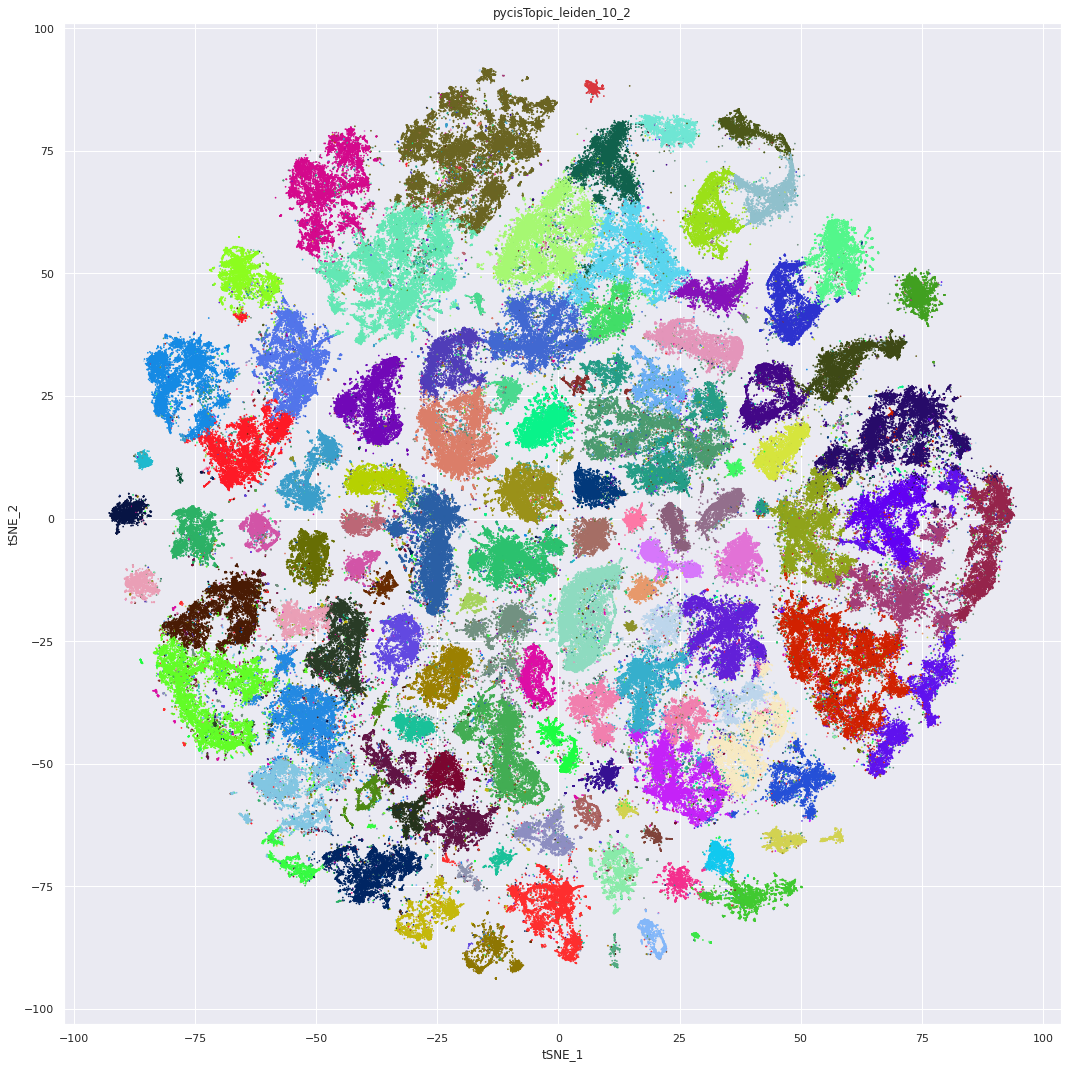

In [13]:
sns.set_theme(style="darkgrid")
plot_metadata(atlas_obj,
              reduction_name='harmony_tSNE',
              variables=[best_clustering], 
              target='cell',
              text_size=15,
              dot_size=0.5,
              figsize=(15,15),
              show_label=False,
              save=None)

In [13]:
# ADD BRAIN ANNOTATIONS 
with open("/staging/leuven/stg_00002/lcb/ijanic/projects/FCA_atac/brain_annot_dict.pkl", "rb") as f:
    cells_annot_dict = pickle.load(f)

In [33]:
atlas_obj.cell_data[["brain_annot"]]

brain_annot
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...            
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...            
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...            
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...            
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...            
...                                                        ...
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...            
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...            
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...            
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...            
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...            

[594940 rows x 1 columns]

In [35]:
from tqdm import tqdm
atlas_obj.cell_data["brain_annot"] = " "
for i in tqdm(range(0, len(atlas_obj.cell_data))):
    barcode = atlas_obj.cell_data.loc[:,"barcode"][i]
    if barcode in cells_annot_dict.keys():
        atlas_obj.cell_data.iloc[i, -1] = cells_annot_dict.get(barcode)
    else:
        atlas_obj.cell_data.iloc[i, -1] = np.nan


100%|██████████| 594940/594940 [01:03<00:00, 9423.51it/s] 


In [4]:
atlas_brain = atlas_obj.cell_data[~atlas_obj.cell_data["brain_annot"].isnull()]
atlas_brain 

cisTopic_nr_frag  \
TGCTCACGTATGCTAC-1___FDM__51c98d__DGRP_mix_adul...             5435   
GGAATCTAGGTCGTTT-1___FDM__51c98d__DGRP_mix_adul...            14721   
TATGTGGGTTCCATCC-1___FDM__51c98d__DGRP_mix_adul...            14715   
CGGTGCATCGCGATGC-1___FDM__51c98d__DGRP_mix_adul...            29174   
GCGCATGTCCCACTAC-1___FDM__51c98d__DGRP_mix_adul...             6350   
...                                                             ...   
CGCTAGGCATACTGCA-1___FDM__e8b47f__DGRP_mix_adul...             1447   
CGCAATATCGTTCCGT-1___FDM__e8b47f__DGRP_mix_adul...              687   
GGTGTCGAGTCGGGAT-1___FDM__e8b47f__DGRP_mix_adul...             2450   
CCCACATTCTCGTGAA-1___FDM__e8b47f__DGRP_mix_adul...             2123   
AGTTACGTCCATCATT-1___FDM__e8b47f__DGRP_mix_adul...             2383   

                                                   cisTopic_log_nr_frag  \
TGCTCACGTATGCTAC-1___FDM__51c98d__DGRP_mix_adul...               3.7352   
GGAATCTAGGTCGTTT-1___FDM__51c98d__DGRP_mix_adul...             4.167937   
TATGTGGGTTCCATCC-1___FDM__51c98d__DGRP_mix_adul...              4.16776   
CGGTGCATCGCGATGC-1___FDM__51c98d__DGRP_mix_adul...             4.464996   
GCGCATGTCCCACTAC-1___FDM__51c98d__DGRP_mix_adul...             3.802774   
...                                                                 ...   
CGCTAGGCATACTGCA-1___FDM__e8b47f__DGRP_mix_adul...             3.160469   
CGCAATATCGTTCCGT-1___FDM__e8b47f__DGRP_mix_adul...             2.836957   
GGTGTCGAGTCGGGAT-1___FDM__e8b47f__DGRP_mix_adul...             3.389166   
CCCACATTCTCGTGAA-1___FDM__e8b47f__DGRP_mix_adul...              3.32695   
AGTTACGTCCATCATT-1___FDM__e8b47f__DGRP_mix_adul...             3.377124   

                                                   cisTopic_nr_acc  \
TGCTCACGTATGCTAC-1___FDM__51c98d__DGRP_mix_adul...            4726   
GGAATCTAGGTCGTTT-1___FDM__51c98d__DGRP_mix_adul...           10262   
TATGTGGGTTCCATCC-1___FDM__51c98d__DGRP_mix_adul...           11811   
CGGTGCATCGCGATGC-1___FDM__51c98d__DGRP_mix_adul...           20134   
GCGCATGTCCCACTAC-1___FDM__51c98d__DGRP_mix_adul...            5692   
...                                                            ...   
CGCTAGGCATACTGCA-1___FDM__e8b47f__DGRP_mix_adul...            1114   
CGCAATATCGTTCCGT-1___FDM__e8b47f__DGRP_mix_adul...             634   
GGTGTCGAGTCGGGAT-1___FDM__e8b47f__DGRP_mix_adul...            2050   
CCCACATTCTCGTGAA-1___FDM__e8b47f__DGRP_mix_adul...            1409   
AGTTACGTCCATCATT-1___FDM__e8b47f__DGRP_mix_adul...            1000   

                                                   cisTopic_log_nr_acc  \
TGCTCACGTATGCTAC-1___FDM__51c98d__DGRP_mix_adul...            3.674494   
GGAATCTAGGTCGTTT-1___FDM__51c98d__DGRP_mix_adul...            4.011232   
TATGTGGGTTCCATCC-1___FDM__51c98d__DGRP_mix_adul...            4.072287   
CGGTGCATCGCGATGC-1___FDM__51c98d__DGRP_mix_adul...             4.30393   
GCGCATGTCCCACTAC-1___FDM__51c98d__DGRP_mix_adul...            3.755265   
...                                                                ...   
CGCTAGGCATACTGCA-1___FDM__e8b47f__DGRP_mix_adul...            3.046885   
CGCAATATCGTTCCGT-1___FDM__e8b47f__DGRP_mix_adul...            2.802089   
GGTGTCGAGTCGGGAT-1___FDM__e8b47f__DGRP_mix_adul...            3.311754   
CCCACATTCTCGTGAA-1___FDM__e8b47f__DGRP_mix_adul...            3.148911   
AGTTACGTCCATCATT-1___FDM__e8b47f__DGRP_mix_adul...                 3.0   

                                                                                            sample_id  \
TGCTCACGTATGCTAC-1___FDM__51c98d__DGRP_mix_adul...  FDM__51c98d__DGRP_mix_adult_fly_head_4_DGRP-40...   
GGAATCTAGGTCGTTT-1___FDM__51c98d__DGRP_mix_adul...  FDM__51c98d__DGRP_mix_adult_fly_head_4_DGRP-40...   
TATGTGGGTTCCATCC-1___FDM__51c98d__DGRP_mix_adul...  FDM__51c98d__DGRP_mix_adult_fly_head_4_DGRP-40...   
CGGTGCATCGCGATGC-1___FDM__51c98d__DGRP_mix_adul...  FDM__51c98d__DGRP_mix_adult_fly_head_4_DGRP-40...   
GCGCATGTCCCACTAC-1___FDM__51c98d__DGRP_mix

In [57]:
len(atlas_obj.cell_data.loc[:, 'pycisTopic_leiden_10_2'].unique())

110

In [58]:
len(atlas_obj.cell_data.loc[:, 'pycisTopic_leiden_10_2_subclustering'].unique())

151

In [6]:
col_names = atlas_brain.loc[:, 'brain_annot'].unique()
col_names

array(['T4', '26', 'unk_03', 'Chiasm glia', 'T5', '98', '97', "KC-a'/b'",
       'Poxn', 'unk_18c', 'Tm20', 'Tm3', 'unknown', 'unk_10d', 'unk_15a',
       'LLPC1', 'T2a', 'T2', 'Mi9', 'unk_15b', 'Subperineurial glia',
       'Perineurial glia', 'unk_04c', 'KC-a/b', 'unk_04a', 'unk_02',
       'Dm3', 'unk_10g', 'unk_13', 'Tm2', 'Pm4', 'unk_10f', 'TmY5a',
       'unk_10c', 'unk_06', 'unk_18d', 'unk_17c', 'C2', '90', 'unk_10a',
       'Cortex glia', 'unk_10b', 'Tm1/TmY8', 'unk_17a', 'L2/L3', 'Tm9',
       'Ensheathing glia', '15b', 'unk_19a', 'unk_18a', 'unk_12', 'KC-g',
       'T3', 'PB4/5', 'unk_01', 'unk_19b', 'Mi1', 'unk_07', 'Tm4',
       'unk_16a', '-', 'T1', 'unk_04b', 'unk_10e', 'Photoreceptors',
       'TmY3', 'Dm8/Dm11', 'unk_18b', 'Mi15', 'C3', 'Astrocyte-like',
       'unk_11', 'unk_17d', '15a', 'unk_05', 'Plasmatocytes', 'unk_16c',
       'NotAssigned', 'unk_16b', 'unk_14', 'unk_17b',
       'CB Developing neuron 1'], dtype=object)

In [ ]:
(len(subset[subset['brain_annot'] == 'unknown'])/len(subset))*100

In [7]:
all_clusters = atlas_brain.loc[:,'pycisTopic_leiden_10_2_subclustering'].unique()
heatmap_df= pd.DataFrame(columns = col_names)
for cluster in all_clusters:
    row = []
    subset = atlas_brain[atlas_brain['pycisTopic_leiden_10_2_subclustering'] == cluster]
    total_cells = len(subset)
    if total_cells != 0:
        for col in heatmap_df.columns:
            row.append((len(subset[subset['brain_annot'] == col])/total_cells) * 100)
    
    row_df = pd.DataFrame([row], columns = col_names, index = [cluster])
    heatmap_df = pd.concat([row_df, heatmap_df])


In [8]:
all_clusters = atlas_brain.loc[:,'pycisTopic_leiden_10_2'].unique()
heatmap_df2= pd.DataFrame(columns = col_names)
for cluster in all_clusters:
    row = []
    subset = atlas_brain[atlas_brain['pycisTopic_leiden_10_2'] == cluster]
    total_cells = len(subset)
    if total_cells != 0:
        for col in heatmap_df2.columns:
            row.append((len(subset[subset['brain_annot'] == col])/total_cells) * 100)
    
    row_df = pd.DataFrame([row], columns = col_names, index = [cluster])
    heatmap_df2 = pd.concat([row_df, heatmap_df2])


In [25]:
for col in heatmap_df2.columns:
    heatmap_df2[col] = heatmap_df2[col].astype(float, errors='raise')
heatmap_df2.dtypes

T4                        float64
26                        float64
unk_03                    float64
Chiasm glia               float64
T5                        float64
                           ...   
NotAssigned               float64
unk_16b                   float64
unk_14                    float64
unk_17b                   float64
CB Developing neuron 1    float64
Length: 82, dtype: object

In [43]:
subclustered_clusters = []
for clust in heatmap_df.index:
    if '.' in clust:
        subclustered_clusters.append(clust)
subclustered_clusters
clusters = {clust.split('.')[0] for clust in subclustered_clusters}
clusters

{'10',
 '13',
 '2',
 '23',
 '27',
 '28',
 '29',
 '31',
 '32',
 '34',
 '36',
 '49',
 '55',
 '57',
 '7',
 '75',
 '86',
 '9',
 '99'}

In [48]:
heatmap_df2 = heatmap_df2.loc[clusters,:]
heatmap_df = heatmap_df.loc[subclustered_clusters, :]

In [55]:
heatmap_df2 = heatmap_df2.drop(columns="-")
heatmap_df = heatmap_df.drop(columns="-")

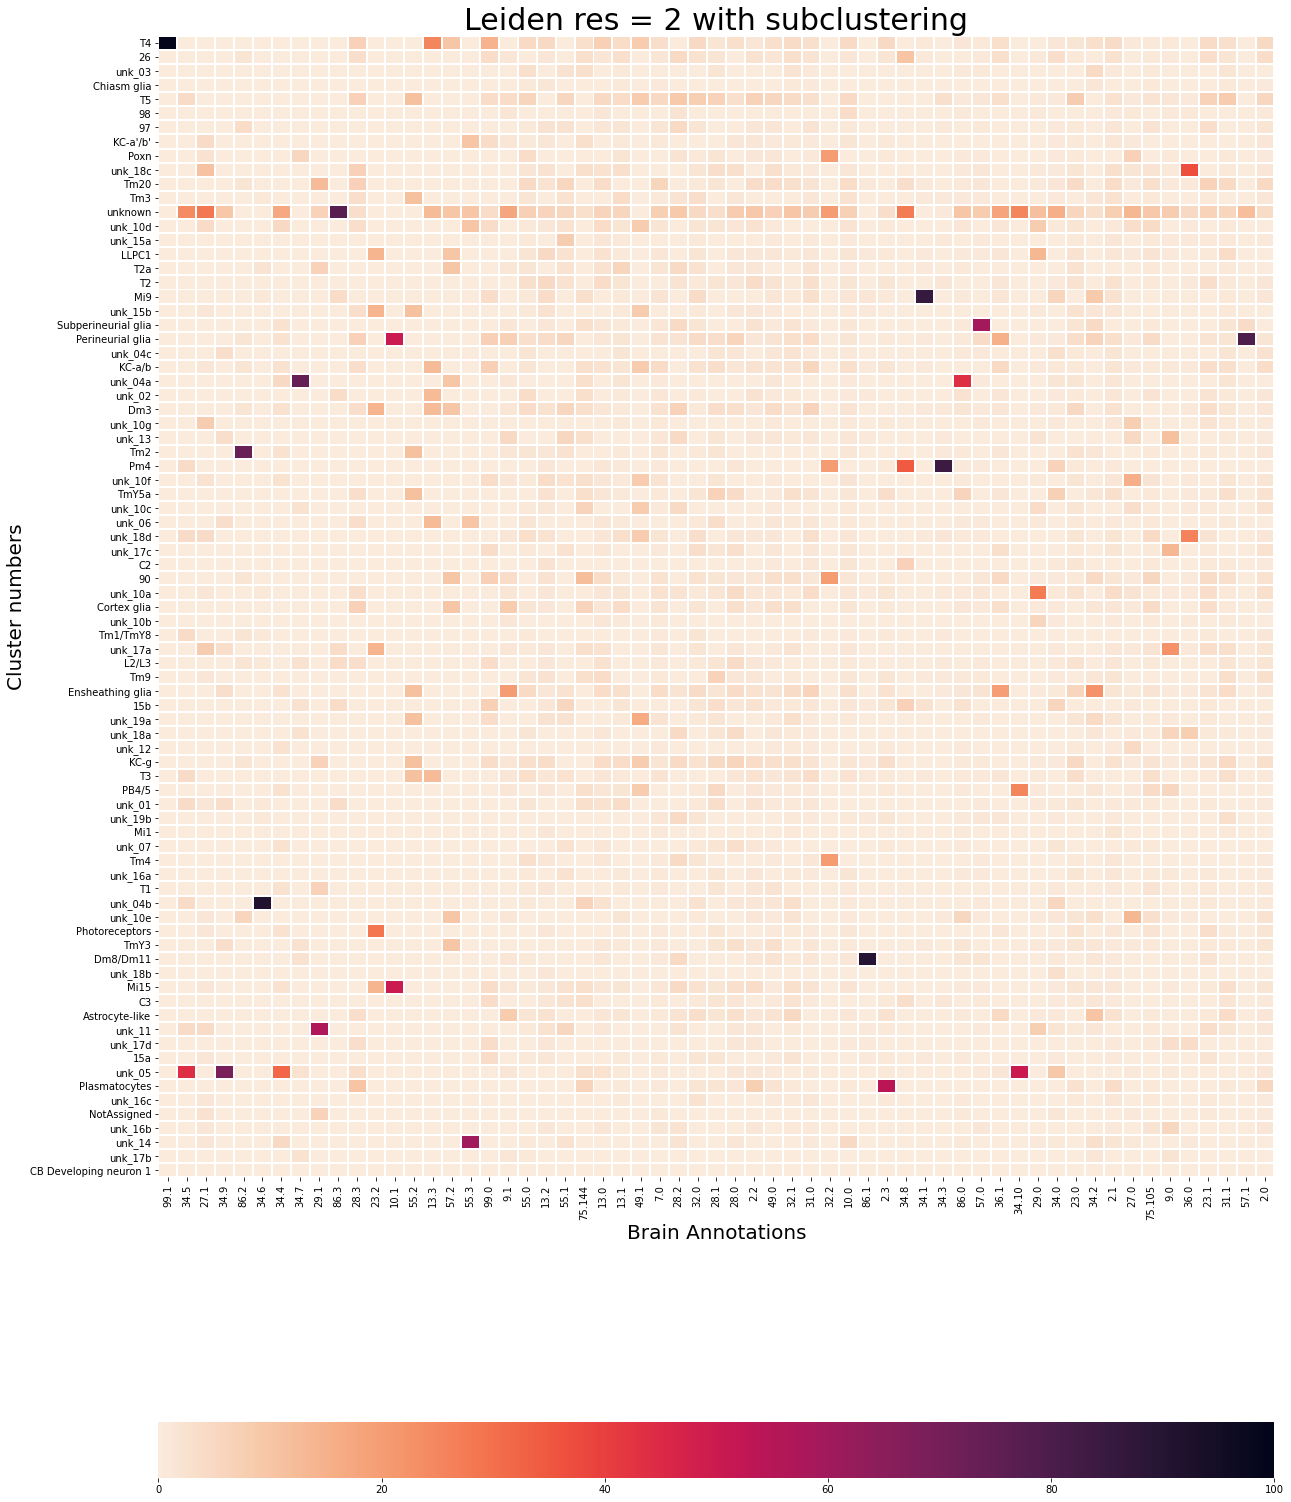

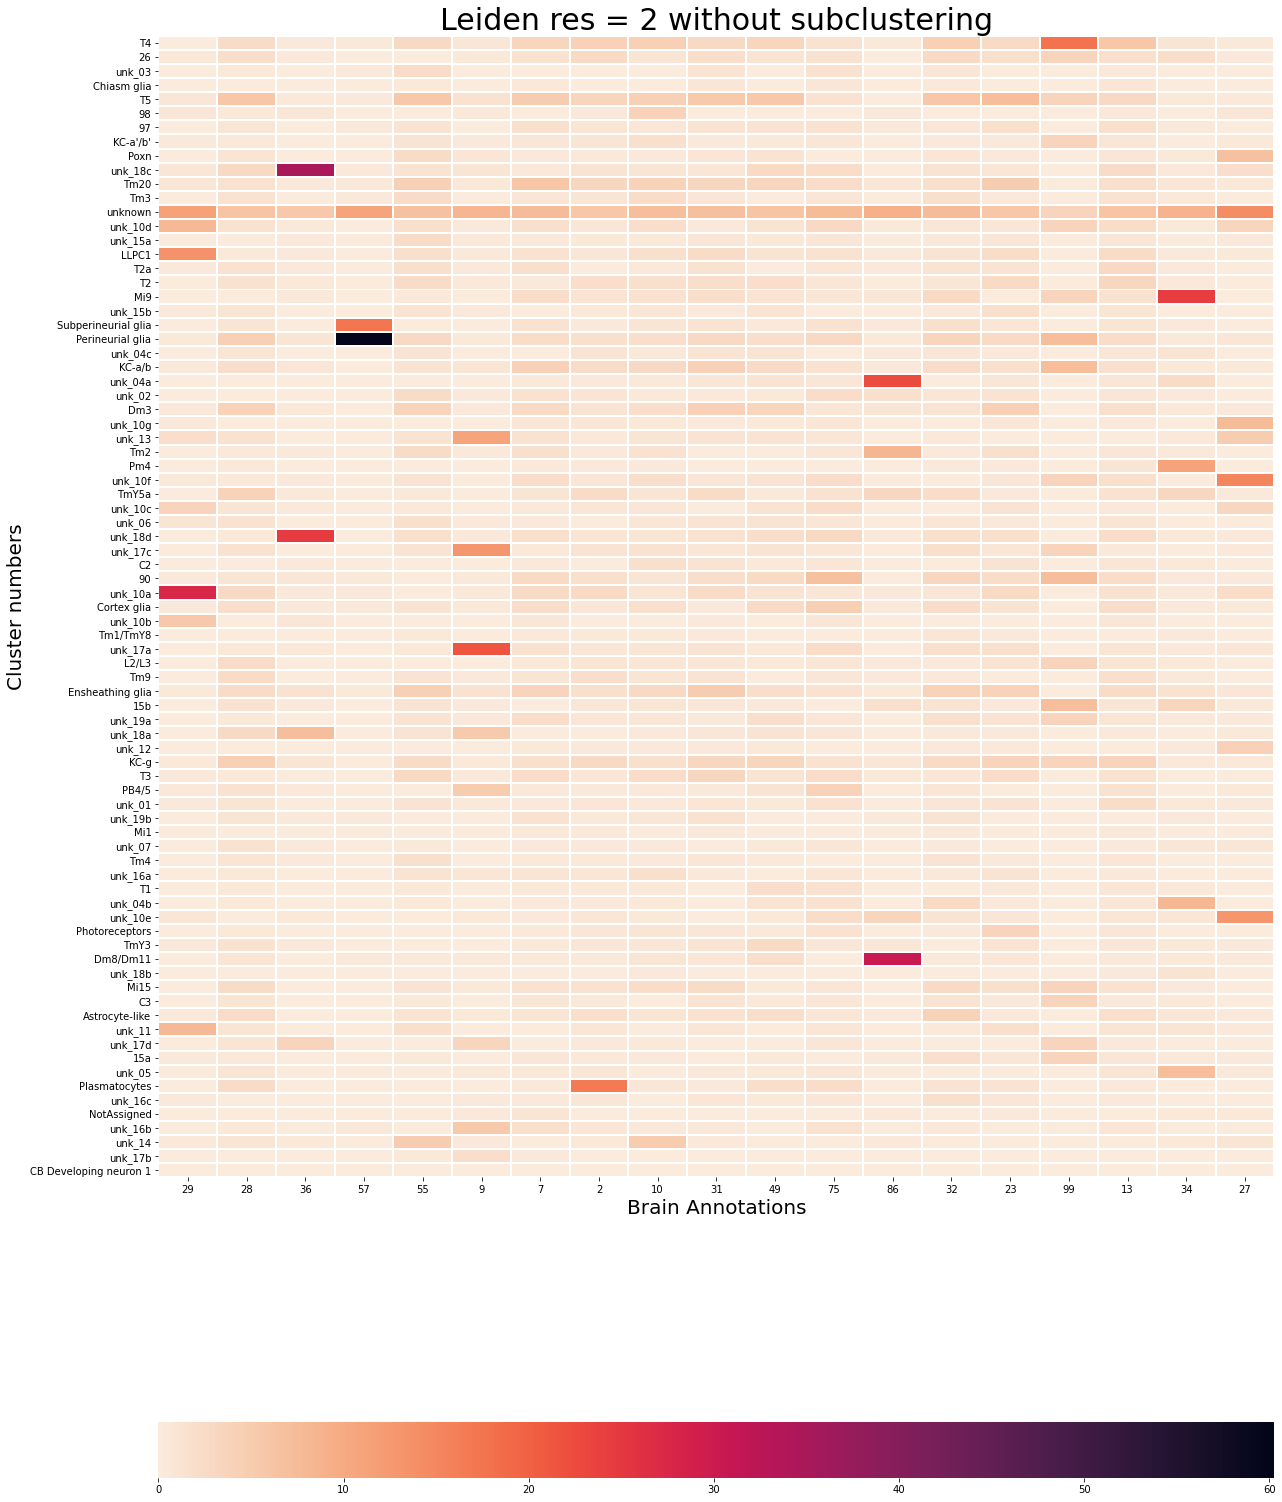

In [57]:
heatmap_df = heatmap_df.dropna()
plt.figure(figsize=(20,30))
sns.heatmap(heatmap_df.T, cmap = 'rocket_r',  cbar_kws={"orientation": "horizontal"}, linewidths=1, linecolor='white',)
plt.title("Leiden res = 2 with subclustering", fontsize = 30)
plt.xlabel("Brain Annotations", fontsize=20)
plt.ylabel("Cluster numbers", fontsize=20)
plt.show()

plt.figure(figsize=(20,30))
heatmap_df2.dropna()
sns.heatmap(heatmap_df2.T, cmap = 'rocket_r',  cbar_kws={"orientation": "horizontal"}, linewidths=1, linecolor='white',)
plt.title("Leiden res = 2 without subclustering", fontsize=30)
plt.xlabel("Brain Annotations", fontsize=20)
plt.ylabel("Cluster numbers", fontsize=20)
plt.show()

In [130]:
sns.set_theme(style='darkgrid')


In [19]:
all_clusters = atlas_brain.loc[:,'pycisTopic_leiden_10_2'].unique()
heatmap_df2= pd.DataFrame(columns = col_names)
for cluster in all_clusters:
    row = []
    subset = atlas_brain[atlas_brain['pycisTopic_leiden_10_2'] == cluster]
    total_cells = len(subset)
    if total_cells != 0:
        for col in heatmap_df.columns:
            row.append((len(subset[subset['brain_annot'] == col])/total_cells) * 100)
    
    row_df = pd.DataFrame([row], columns = col_names, index = [cluster])
    heatmap_df2 = pd.concat([row_df, heatmap_df2])


In [156]:
for col in heatmap_df2.columns:
    heatmap_df2[col] = heatmap_df2[col].astype(float, errors='raise')
heatmap_df2.dtypes

T4                        float64
26                        float64
unk_03                    float64
Chiasm glia               float64
T5                        float64
                           ...   
NotAssigned               float64
unk_16b                   float64
unk_14                    float64
unk_17b                   float64
CB Developing neuron 1    float64
Length: 82, dtype: object

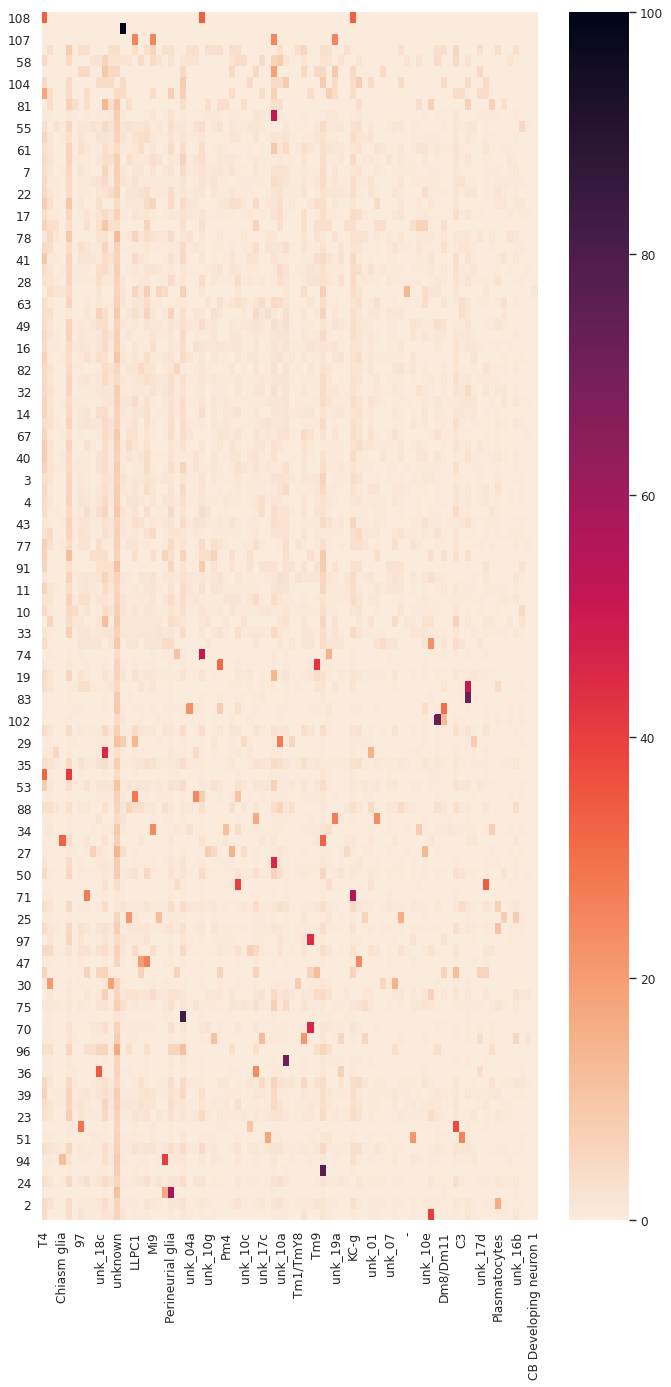

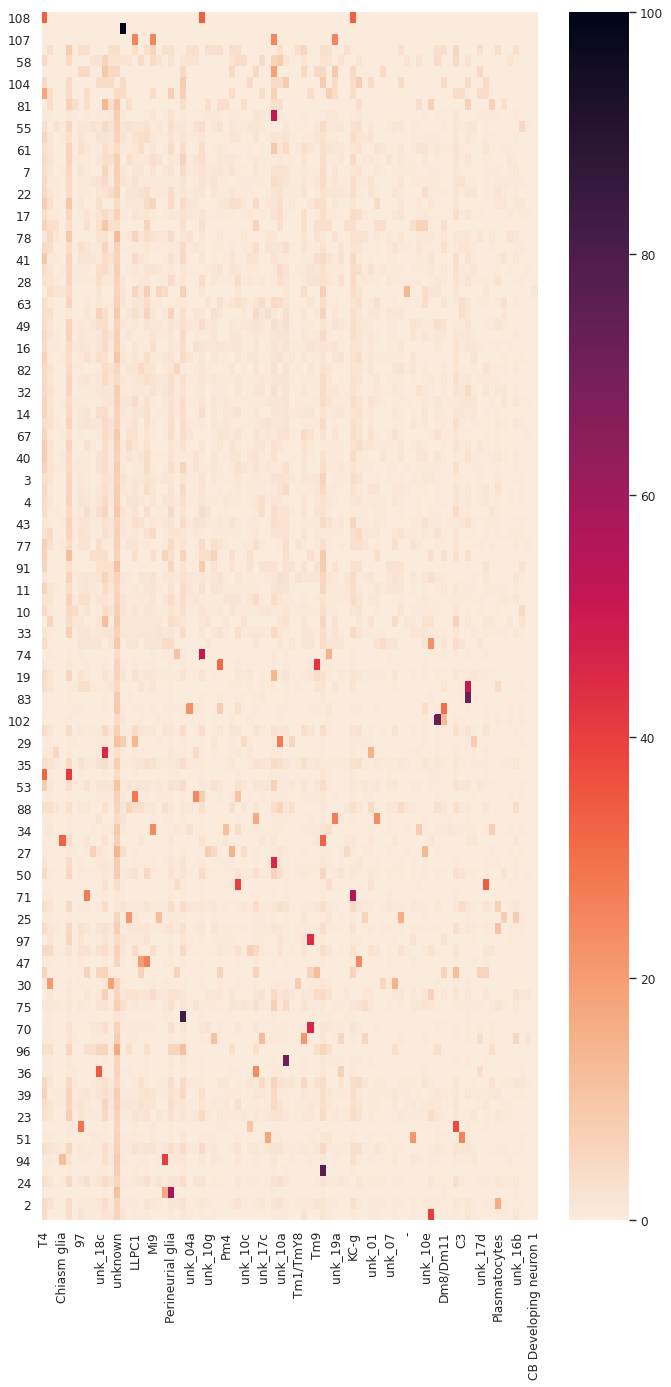

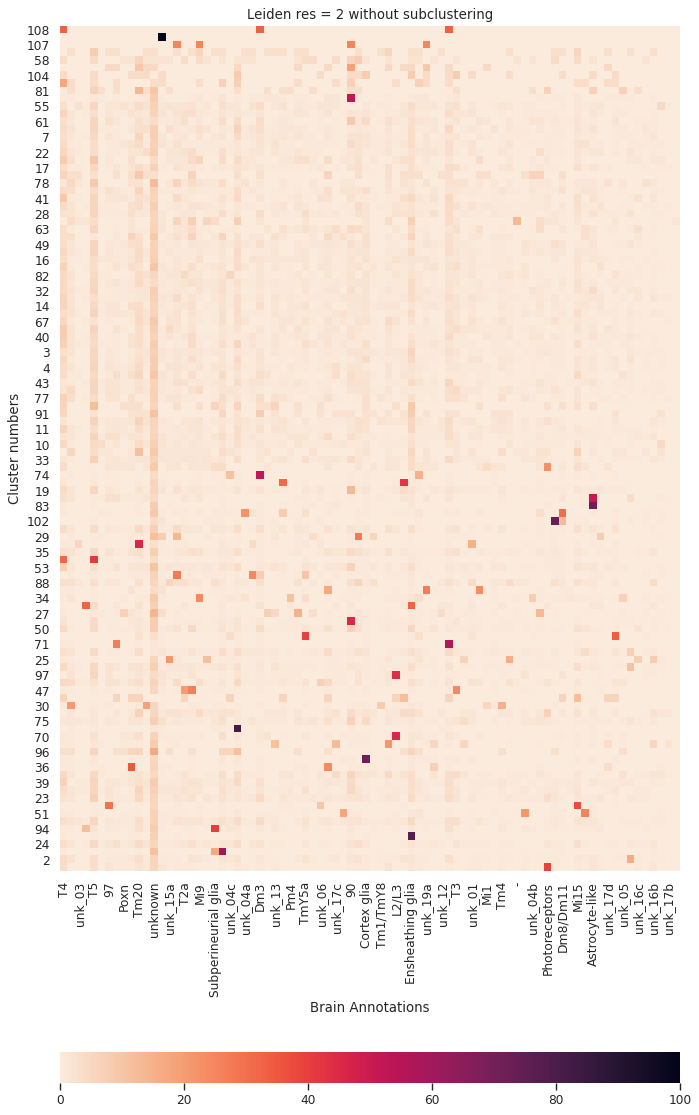

In [198]:
heatmap_df2 = heatmap_df2.dropna()
plt.figure(figsize=(10, 20), dpi=80)
sns.heatmap(heatmap_df2, cmap = 'rocket_r',  cbar_kws={"orientation": "horizontal"})
plt.title("Leiden res = 2 without subclustering")
plt.xlabel("Brain Annotations")
plt.ylabel("Cluster numbers")
plt.show()

/staging/leuven/stg_00002/lcb/sfloc/software/miniconda3/envs/python_dinghy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/staging/leuven/stg_00002/lcb/sfloc/software/miniconda3/envs/python_dinghy/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


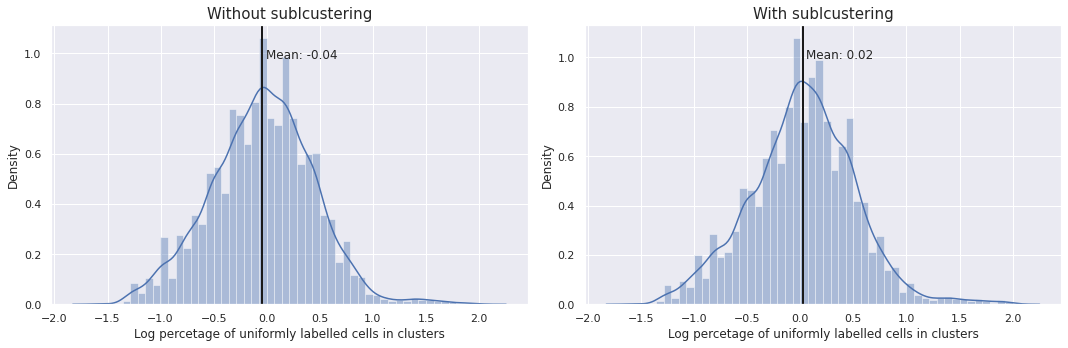

In [225]:
def avg(lst):
    return sum(lst) / len(lst)

fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.set_theme(style='darkgrid')
vals = heatmap_df.values.flatten()
l1 = [math.log10(num) for num in vals if num != 0]
vals = heatmap_df2.values.flatten()
l2 = [math.log10(num) for num in vals if num != 0]
sns.distplot(l2, ax=axs[0])
axs[0].set_title('Without sublcustering', fontsize=15)
axs[0].set_xlabel("Log percetage of uniformly labelled cells in clusters")
axs[0].axvline(avg(l2), color='k', linestyle='solid', linewidth=2)
min_ylim, max_ylim = plt.ylim()
axs[0].text(avg(l2)*0.2, max_ylim*0.98, 'Mean: {:.2f}'.format(avg(l2)))

sns.distplot(l1, ax=axs[1])
axs[1].set_title('With sublcustering', fontsize = 15)
axs[1].set_xlabel("Log percetage of uniformly labelled cells in clusters")
axs[1].axvline(avg(l1), color='k', linestyle='solid', linewidth=2)
min_ylim, max_ylim = plt.ylim()
axs[1].text(avg(l1)*2.2, max_ylim*0.88, 'Mean: {:.2f}'.format(avg(l1)))

fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.show()
 

In [226]:
from scipy import stats
stats.levene(l1, l2)

LeveneResult(statistic=0.2696687233023879, pvalue=0.6035630362641183)

In [227]:
stats.shapiro(l1)

/staging/leuven/stg_00002/lcb/sfloc/software/miniconda3/envs/python_dinghy/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9921250939369202, pvalue=5.930620811197074e-19)

In [228]:
stats.shapiro(l2)

ShapiroResult(statistic=0.9943478107452393, pvalue=9.762618841048683e-15)

In [229]:
stats.ranksums(l1, l2)

RanksumsResult(statistic=7.45684943401954, pvalue=8.861587027742107e-14)

In [ ]:
all_clusters = atlas_brain.loc[:,'pycisTopic_leiden_10_2'].unique()
heatmap_df= pd.DataFrame(columns = col_names)
for cluster in all_clusters:
    row = []
    subset = atlas_brain[atlas_brain['pycisTopic_leiden_10_2'] == cluster]
    total_cells = len(subset)
    if total_cells != 0:
        for col in heatmap_df.columns:
            row.append(jaccard(subset.index, atlas_brain[atlas_brain['brain_annot'] == col].index))
          
    row_df = pd.DataFrame([row], columns = col_names, index = [cluster])
    heatmap_df = pd.concat([row_df, heatmap_df])

f

In [ ]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [ ]:
subset = atlas_brain[atlas_brain['pycisTopic_leiden_10_5'] == '50']

In [ ]:
heatmap_df.to_csv("/data/leuven/338/vsc33893/jupyterhub_notebooks/thesis/heatmap_df_res30.csv")

In [154]:
import seaborn as sns

def select_clusters(atlas_obj, best_clustering, n, plot_count_distribution=True):
    # Count cells per cluster
    clusters_counts = atlas_obj.cell_data[[best_clustering]].value_counts()
    #clusters = [row[0] for row in clusters_counts.index] # retrieve the cluster labels
    
    # Get 'n' worst scoring clusters
    clusters_worst_sil = atlas_obj.cell_data.sort_values(by = "Silhouette_scores_per_cluster_"+ best_clustering).loc[:, best_clustering]
    clusters_worst_sil = clusters_worst_sil.unique()[:n]
    
    # Get cell counts for the worst-scoring clusters
    clusters_df = pd.DataFrame()
    clusters_df["label"] = [clusters_counts.index[i][0] for i in range(0, len(clusters_counts)) if clusters_counts.index[i] in clusters_worst_sil]
    clusters_df["cell_counts"] = [clusters_counts[i] for i in range(0, len(clusters_counts)) if clusters_counts.index[i] in clusters_worst_sil]
    if plot_count_distribution:
        sns.set_theme(style="darkgrid")
        ax = sns.barplot(x="label", y="cell_counts", data=clusters_df,  palette="Blues_d")
        plt.xlabel("Cluster labels")
        plt.ylabel("Cell counts")
        plt.title(f"Cell counts of the {n-1} worst scoring clusters")
        plt.show()
    return clusters_worst_sil

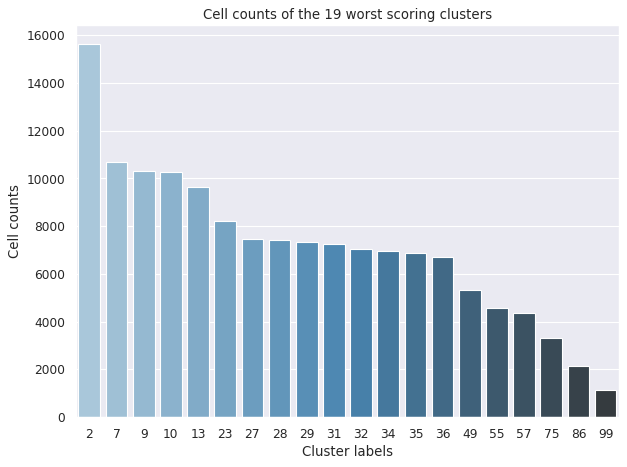

In [155]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
clusters = select_clusters(atlas_obj, best_clustering, 20, True)

showstart, tmux, qstat, superdome interactive session (reserve one node - 14cpu) 
run jupyer lab. 

writte to sten
harmony 

pseudobulk step 
* cis target region - peaks generageted by the lab (conservation scores - the parts conserved acress species of DM it might be of importance --> regulatory region)
    * high conservation score 
    * hight conserved scores --> peaks infered based on the conservation score
* take our own signal - take region that have significan peaks  
* specific set of peaks -> where are the peaks 
    * one population cells -> enrichming for the globally accesible peaks 
    * call the peaks per cluster 
    * finding peaks specific for the cell types 


Create pseudobulk for each clusters
* cistopic fist pseudobulk 
Stein to one slide -> solhouette score 
* heat for the brain aanotation 
    * brain 10x data + heatmap
    

In [ ]:
clusters 

In [ ]:
['99', '29', '32', '35', '13', '57', '2']

In [ ]:
atlas_obj.cell_data[['Silhouette_scores_per_cluster_'+ best_clustering]]

In [ ]:
def calculate_subclustering(clusters, best_clustering, atlas_obj, outDir):
    without_subclustering_score = {}
    with_subclustering_score = {}
    for cluster in clusters:
        file_labels = open(f"/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/scores{cluster}.txt", 'a')
        subcluster = atlas_obj.cell_data[atlas_obj.cell_data[best_clustering] == cluster]
        cells = [i for i in subcluster.index]
        subcluster_obj = atlas_obj.subset(cells, copy=True, split_pattern='-')
        # Mallet run of models
        os.putenv('JAVA_HOME','/data/leuven/software/biomed/haswell_centos7/2018a/software/Java/1.8.0_221')
        os.environ["PATH"] += os.pathsep + '/data/leuven/software/biomed/haswell_centos7/2018a/software/Java/1.8.0_221/bin:'
        os.putenv('MALLET_HOME','/staging/leuven/stg_00002/lcb/cbravo/software/Mallet/')
        path_to_mallet_binary='/staging/leuven/stg_00002/lcb/cbravo/software/Mallet/bin/mallet'
        
        print("Running LDA modelling")
        # Run models
        models = run_cgs_models(atlas_obj,
                n_topics=[20, 40, 60, 80, 90, 100],
                n_cpu=6,
                n_iter=100,
                random_state=555,
                alpha=50,
                alpha_by_topic=True,
                eta=0.1,
                eta_by_topic=False,
                _temp_dir='/scratch/leuven/338/vsc33893/ray_spill',
                _plasma_directory='/scratch/leuven/338/vsc33893/plasma')

        
        print("Evaluating the modelling")
        best_model = evaluate_models(models,
                                     select_model=None,
                                     return_model=True,
                                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                                     min_topics_coh=0, # with this all points on Mimno plot are displayed
                                     plot_metrics=False)
        # Save modelled obj and figure of best models
        plt.savefig(outDir + f'/modelling/best_models_subcluster{cluster}.pdf')
        subcluster_obj.add_LDA_model(best_model)
        with open(outDir + f'/modelling/modelled_subcluster_{cluster}_obj.pkl', 'wb') as f:
            pickle.dump(subcluster_obj, f)
        run_tsne(subcluster_obj, target  = 'cell', harmony = False, reduction_name="tSNE") 
        
        print("Caclulating Leiden clustering...")
        subcluster_obj = clustering(subcluster_obj)
        
        print("Cacluating distance matrix for Silhouette score evaluation")
        data_mat = subcluster_obj.selected_model.cell_topic
        data_mat = data_mat.T
        dist_mat = pd.DataFrame(squareform(pdist(data_mat)),
                                columns=data_mat.index,
                                index=data_mat.index)
        
        print("Evaluating clustering with silhouette score")
        scores, labels = eval_clustering(subcluster_obj, dist_mat, 1, "pycisTopic_leiden*")
        plot_clustering(scores, labels, "silhouette_score", outDir+f'/clustering/silhouette_score_subcluster{cluster}.pdf')
        
        print("Plotting the best clustering")
        plot_metadata(subcluster_obj,
                     reduction_name='tSNE',
                     variables=[labels[scores.index(max(scores))]], 
                     target='cell',
                     text_size=15,
                     dot_size=10,
                     figsize=(15,15),
                     show_label = True,
                     save=outDir+f'/clustering/best_subclustering_for_{cluster}.pdf')
        # save the silhouette scores of sublustered and not subclustered clusters
        without_subclustering_score[cluster] = subcluster_obj.cell_data[['Silhouette_scores_per_cluster_'+ best_clustering]]
        with_subclustering_score[cluster] = max(scores)
        file.write(without_subclustering_score[cluster])
        file.write(with_subclustering_score[cluster])
    with open(outDir + f'/clustering/score_without_subclustering.pkl', 'wb') as f:
        pickle.dump(without_subclustering_score, f)
        
    with open(outDir + f'/clustering/score_with_subclustering.pkl', 'wb') as f:
        pickle.dump(with_subclustering_score, f)

        
        

### Results

In [44]:
import glob
resList = glob.glob('/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/scores*.txt')
print(len(resList))

scores_with_subclustering = {}
for path in resList:
    cluster_num = re.split(r'scores|.txt', path)[-2]
    with open(path, 'r') as f:
        score = f.read()
    scores_with_subclustering[cluster_num] = float(score)
        
print(scores_with_subclustering)

19
{'34': 0.18451077892910184, '49': 0.6710331913934872, '32': 0.23739887812617017, '36': 0.1902707745818809, '7': 0.7397773753223669, '75': 0.36830065422835445, '2': 0.10692654394300083, '10': 0.4190586887148654, '13': 0.16624476751213843, '9': 0.08864530512696787, '23': 0.5695301343096739, '29': 0.3304651883863254, '31': 0.30048996344967477, '86': 0.4379358381767525, '27': 0.2976474145654072, '55': -0.017622070982215864, '28': 0.11369737840784146, '99': 0.6099787125360647, '57': 0.25343770590387926}


In [45]:
scores_wo_subclustering={}
for i in range(0, len(atlas_obj.cell_data.loc[:,'pycisTopic_leiden_10_2'])):
    cluster_num = atlas_obj.cell_data.loc[:,'pycisTopic_leiden_10_2'][i]
    if cluster_num not in scores_wo_subclustering.keys() and cluster_num in scores_with_subclustering.keys():
        scores_wo_subclustering[cluster_num] = atlas_obj.cell_data.loc[:,'Silhouette_scores_per_cluster_pycisTopic_leiden_10_2'][i]
scores_wo_subclustering

{'31': 0.07302956882751317,
 '2': -0.028057965947611306,
 '36': 0.06380341958807545,
 '28': 0.03929928799430818,
 '57': 0.0641643954717487,
 '13': 0.05164113225965763,
 '49': 0.04453044948293472,
 '32': 0.039865469127016245,
 '55': -0.051861663207775015,
 '7': -0.09749247088826808,
 '23': -0.03548363530979802,
 '10': -0.0853735879853433,
 '9': 0.02621803507185849,
 '27': 0.053494684420612414,
 '75': 0.04040308819131291,
 '34': 0.06926853029327724,
 '29': -0.01819726830799913,
 '99': -0.041123821164584504,
 '86': 0.012956002943463881}

In [ ]:
def get_best_clustering_pattern(scores_with_subclustering, scores_without_subclustering):
    best_clustering_pattern = {}
    for key in scores_with_subclustering.keys():
        if scores_with_subclustering.get(key) > scores_without_subclustering.get(key):
            print(scores_with_subclustering.get(key))
            print(scores_without_subclustering.get(key))
            best_clustering_pattern[key] = "with_subclustering"
        else:
            best_clustering_pattern[key] = "without_subclustering"
    return best_clustering_pattern

In [49]:
#best_clustering_pattern = get_best_clustering_pattern(scores_with_subclustering, scores_wo_subclustering)
best_clustering_variable = "pycisTopic_leiden_10_2"
new_clusters, subclustering_variables = integrate_subclustering(scores_wo_subclustering, atlas_obj, best_clustering_variable)

2022-05-04 18:36:34,637 cisTopic     INFO     Finding neighbours
Columns ['pycisTopic_leiden_10_0.2'] will be overwritten
Columns ['pycisTopic_leiden_10_0.4'] will be overwritten
Columns ['pycisTopic_leiden_10_0.5'] will be overwritten
Columns ['pycisTopic_leiden_10_0.6'] will be overwritten
Columns ['pycisTopic_leiden_10_0.7'] will be overwritten
Columns ['pycisTopic_leiden_10_0.8'] will be overwritten
Columns ['pycisTopic_leiden_10_0.9'] will be overwritten
Columns ['pycisTopic_leiden_10_1'] will be overwritten
Columns ['pycisTopic_leiden_10_1.2'] will be overwritten
Columns ['pycisTopic_leiden_10_2'] will be overwritten
Cacluating distance matrix for Silhouette score evaluation
Evaluating clustering with silhouette score
calcuating score for cluster pycisTopic_leiden_10_60
skipping cluster pycisTopic_leiden_10_0.04
calcuating score for cluster pycisTopic_leiden_10_1.6
calcuating score for cluster pycisTopic_leiden_10_0.2
calcuating score for cluster pycisTopic_leiden_10_0.3
skipping

In [50]:
new_atlas = integrate_clusters(atlas_obj, new_clusters, best_clustering_variable, subclustering_variables)

In [51]:
new_atlas.cell_data

cisTopic_nr_frag  \
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...            11880   
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...             4991   
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...             6007   
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...             3051   
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...             9830   
...                                                             ...   
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...              957   
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...             3249   
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...              953   
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...             2468   
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...             1814   

                                                   cisTopic_log_nr_frag  \
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...             4.074816   
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...             3.698188   
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...             3.778658   
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...             3.484442   
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...             3.992554   
...                                                                 ...   
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...             2.980912   
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...              3.51175   
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...             2.979093   
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...             3.392345   
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...             3.258637   

                                                   cisTopic_nr_acc  \
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...            8783   
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...            4179   
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...            5027   
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...            2754   
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...            7021   
...                                                            ...   
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...             799   
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...            2816   
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...             916   
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...            2222   
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...            1443   

                                                   cisTopic_log_nr_acc  \
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...            3.943643   
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...            3.621072   
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...            3.701309   
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...            3.439964   
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...            3.846399   
...                                                                ...   
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...            2.902547   
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...            3.449633   
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...            2.961895   
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...            3.346744   
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...            3.159266   

                                                                                            sample_id  \
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...  FDM__ec5baa__20210511__20210601_hydrop-atac_fl...   
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...  FDM__ec5baa__20210511__20210601_hydrop-atac_fl...   
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...  FDM__ec5baa__20210511__20210601_hydrop-atac_fl...   
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...  FDM__ec5baa__20210511__20210601_hydrop-atac_fl...   
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5b

In [42]:
def integrate_subclustering(scores_wo_subclustering, atlas_obj, best_clustering_variable):
    new_clusters = {}
    subclustering_variables = {}
    outDir="/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/results"
    for cluster_num in scores_wo_subclustering.keys():
        path = f"/modelling/modelled_subcluster_{cluster_num}_obj.pkl"
        with open(outDir+path, "rb") as f:
            subcluster_obj = pickle.load(f)
        subcluster_obj =clustering(subcluster_obj)
        print("Cacluating distance matrix for Silhouette score evaluation")
        data_mat = subcluster_obj.selected_model.cell_topic
        data_mat = data_mat.T
        dist_mat = pd.DataFrame(squareform(pdist(data_mat)),
                                columns=data_mat.index,
                                index=data_mat.index)
        
        print("Evaluating clustering with silhouette score")
        scores, labels = eval_clustering(subcluster_obj, dist_mat, 1, "pycisTopic_leiden*")
        print(f"subclustering avg score: {max(scores)}, the orginal score: {scores_wo_subclustering.get(cluster_num)}")
        if(max(scores) > scores_wo_subclustering.get(cluster_num)):
            print(f"#######Cluster nuber {cluster_num} will be integrated######")
            subclustering_variable = labels[scores.index(max(scores))]
            subclustering_obj = add_silhouette_score_per_cluster_col(subclustering_variable, subcluster_obj)
            new_clusters[cluster_num]=subcluster_obj
            subclustering_variables[cluster_num]=subclustering_variable
        else:
            print((f"#######Cluster nuber {cluster_num} will not be integrated######"))
    return new_clusters, subclustering_variables

In [52]:
outDir="/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/results"
cluster_num = '31'
path = f"/modelling/modelled_subcluster_{cluster_num}_obj.pkl"
with open(outDir+path, "rb") as f:
    subcluster_obj = pickle.load(f)
subcluster_obj =clustering(subcluster_obj)
print("Cacluating distance matrix for Silhouette score evaluation")
data_mat = subcluster_obj.selected_model.cell_topic
data_mat = data_mat.T
dist_mat = pd.DataFrame(squareform(pdist(data_mat)),
                        columns=data_mat.index,
                        index=data_mat.index)

print("Evaluating clustering with silhouette score")
scores, labels = eval_clustering(subcluster_obj, dist_mat, 1, "pycisTopic_leiden*")
print(f"subclustering avg score: {max(scores)}, the orginal score: {scores_wo_subclustering.get(cluster_num)}")
if(max(scores) > scores_wo_subclustering.get(cluster_num)):
    print(f"#######Cluster nuber {cluster_num} will be integrated######")
    subclustering_obj = add_silhouette_score_per_cluster_col(subclustering_variable, subcluster_obj)
    #new_clusters[cluster_num]=subcluster_obj
    #subclustering_variables[cluster_num]=labels[scores.index(max(scores))]
else:
    print((f"#######Cluster nuber {cluster_num} will not be integrated######"))
subclustering_obj.cell_data

2022-05-02 13:42:38,976 cisTopic     INFO     Finding neighbours
Columns ['pycisTopic_leiden_10_0.2'] will be overwritten
Columns ['pycisTopic_leiden_10_0.4'] will be overwritten
Columns ['pycisTopic_leiden_10_0.5'] will be overwritten
Columns ['pycisTopic_leiden_10_0.6'] will be overwritten
Columns ['pycisTopic_leiden_10_0.7'] will be overwritten
Columns ['pycisTopic_leiden_10_0.8'] will be overwritten
Columns ['pycisTopic_leiden_10_0.9'] will be overwritten
Columns ['pycisTopic_leiden_10_1'] will be overwritten
Columns ['pycisTopic_leiden_10_1.2'] will be overwritten
Columns ['pycisTopic_leiden_10_2'] will be overwritten
Cacluating distance matrix for Silhouette score evaluation
Evaluating clustering with silhouette score
calcuating score for cluster pycisTopic_leiden_10_1.2
calcuating score for cluster pycisTopic_leiden_10_0.7
calcuating score for cluster pycisTopic_leiden_10_1.8
calcuating score for cluster pycisTopic_leiden_10_0.2
calcuating score for cluster pycisTopic_leiden_10_

Log_total_nr_frag  \
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...           3.907680   
GTGTGAAGAACTTGATTACGCTGGAACACG___FDM__ec5baa__2...           3.710371   
GTGCCAATAAGACGGACGGTAACGCCTGCT___FDM__ec5baa__2...           3.879211   
GCATCAGAAGATTCGGTCAGCATTAACCTC___FDM__ec5baa__2...           3.991359   
CACTGGTGGTTGAACCTTACAGGACGACTG___FDM__ec5baa__2...           3.981320   
...                                                               ...   
GGAACTTTCGTAGCGC-1___FDM__e8b47f__DGRP_mix_adul...           3.208710   
TAGGCTGTCGGTTTCC-1___FDM__185acd__20220207_MO_c...           3.142389   
CTGCTATGTCTCACTG-1___FDM__185acd__20220207_MO_c...           3.159567   
CAGCATTAGTAGGCGG-1___FDM__185acd__20220207_MO_c...           3.042576   
CCAAACCCATCGCTTT-1___FDM__185acd__20220207_MO_c...           3.073352   

                                                   pycisTopic_leiden_10_1.2  \
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...                       12   
GTGTGAAGAACTTGATTACGCTGGAACACG___FDM__ec5baa__2...                        0   
GTGCCAATAAGACGGACGGTAACGCCTGCT___FDM__ec5baa__2...                       13   
GCATCAGAAGATTCGGTCAGCATTAACCTC___FDM__ec5baa__2...                        3   
CACTGGTGGTTGAACCTTACAGGACGACTG___FDM__ec5baa__2...                        7   
...                                                                     ...   
GGAACTTTCGTAGCGC-1___FDM__e8b47f__DGRP_mix_adul...                        3   
TAGGCTGTCGGTTTCC-1___FDM__185acd__20220207_MO_c...                        4   
CTGCTATGTCTCACTG-1___FDM__185acd__20220207_MO_c...                        4   
CAGCATTAGTAGGCGG-1___FDM__185acd__20220207_MO_c...                        4   
CCAAACCCATCGCTTT-1___FDM__185acd__20220207_MO_c...                        8   

                                                   pycisTopic_leiden_10_0.7  \
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...                        0   
GTGTGAAGAACTTGATTACGCTGGAACACG___FDM__ec5baa__2...                        1   
GTGCCAATAAGACGGACGGTAACGCCTGCT___FDM__ec5baa__2...                        3   
GCATCAGAAGATTCGGTCAGCATTAACCTC___FDM__ec5baa__2...                        0   
CACTGGTGGTTGAACCTTACAGGACGACTG___FDM__ec5baa__2...                        7   
...                                                                     ...   
GGAACTTTCGTAGCGC-1___FDM__e8b47f__DGRP_mix_adul...                        0   
TAGGCTGTCGGTTTCC-1___FDM__185acd__20220207_MO_c...                        0   
CTGCTATGTCTCACTG-1___FDM__185acd__20220207_MO_c...                        0   
CAGCATTAGTAGGCGG-1___FDM__185acd__20220207_MO_c...                        3   
CCAAACCCATCGCTTT-1___FDM__185acd__20220207_MO_c...                        3   

                                                   pycisTopic_leiden_10_1.8  \
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...                       31   
GTGTGAAGAACTTGATTACGCTGGAACACG___FDM__ec5baa__2...                       31   
GTGCCAATAAGACGGACGGTAACGCCTGCT___FDM__ec5baa__2...                       31   
GCATCAGAAGATTCGGTCAGCATTAACCTC___FDM__ec5baa__2...                       31   
CACTGGTGGTTGAACCTTACAGGACGACTG___FDM__ec5baa__2...                       31   
...                                                                     ...   
GGAACTTTCGTAGCGC-1___FDM__e8b47f__DGRP_mix_adul...                       31   
TAGGCTGTCGGTTTCC-1___FDM__185acd__20220207_MO_c...                       31   
CTGCTATGTCTCACTG-1___FDM__185acd__20220207_MO_c...                       31   
CAGCATTAGTAGGCGG-1___FDM__185acd__20220207_MO_c...                       31   
CCAAACCCATCGCTTT-1___FDM__185acd__20220207_MO_c...                       31   

                                                   pycisTopic_leiden_10_0.2  \
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...                        2   
GTGTGAAGAACTTGATTACGCTGGAACACG___FDM__ec5baa__2...                        1   
GTGCCAATAAGACGGACGGTAACGCCTGCT___FDM__ec5baa__2...                        0   
GCATCAGAAGAT

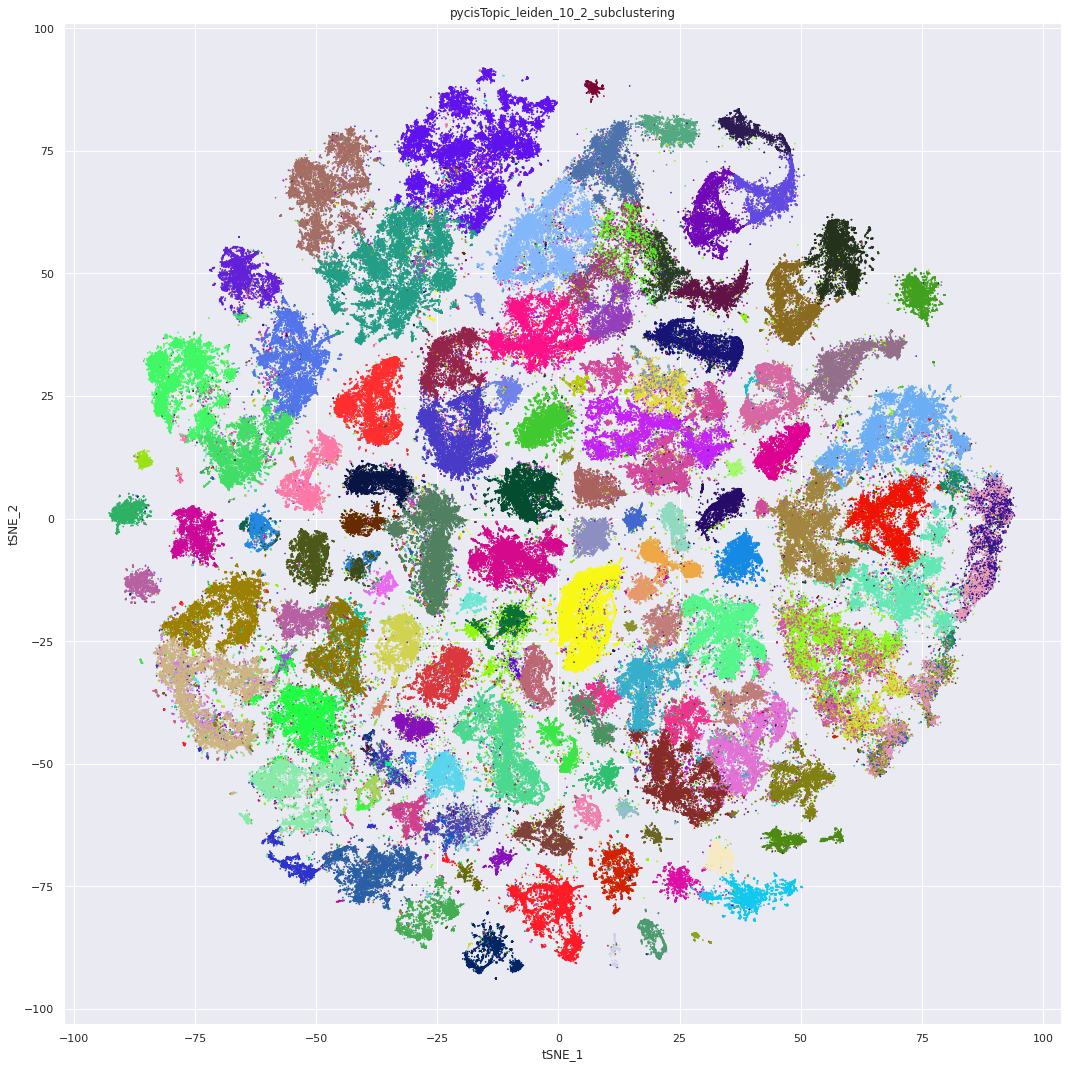

In [12]:
plot_metadata(atlas_obj,
             reduction_name='harmony_tSNE',
             variables=['pycisTopic_leiden_10_2_subclustering'], 
             target='cell',
             text_size=10,
             dot_size=0.5,
             figsize=(15,15),
             show_label = False,
             save=None)

In [ ]:
var = best_clustering+'_subclustering'
new_atlas = add_silhouette_score_per_cluster_col(var, atlas_obj)
plot_metadata(atlas_obj,
              reduction_name='harmony_tSNE',
              variables=["Silhouette_scores_per_cluster_"+ var], 
              target='cell',
              text_size=15,
              dot_size=10,
              figsize=(15,15),
              show_label=True,
              cmap=cm.hot,
              save=None)

In [ ]:
plot_metadata(atlas_obj,
              reduction_name='harmony_tSNE',
              variables=["Silhouette_scores_per_cluster_"+ best_clustering], 
              target='cell',
              text_size=15,
              dot_size=5,
              figsize=(15,15),
              show_label=True,
              cmap=cm.hot,
              save=None)

In [8]:
#get tsne embeddings with silhouette score
best_clustering = 'pycisTopic_leiden_10_2'
var = best_clustering+'_subclustering'
embeddings = pd.DataFrame()
embeddings = atlas_obj.projections.get('cell').get('harmony_tSNE')
embeddings["clustering"] = atlas_obj.cell_data.loc[:, "Silhouette_scores_per_cluster_"+ best_clustering]
embeddings["subclustering"] = atlas_obj.cell_data.loc[:, "Silhouette_scores_per_cluster_"+ var]
embeddings

tSNE_1     tSNE_2  \
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...   9.985531  -5.097736   
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2... -42.810438  -2.514944   
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...   9.324812  -6.410230   
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...  10.724133 -37.364444   
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...  57.674729  28.580313   
...                                                       ...        ...   
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...  15.619431  34.965418   
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...  30.509741  13.419594   
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...  19.160930  23.023488   
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...  28.572497  24.625886   
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...   7.041725  26.019514   

                                                    clustering  subclustering  
ACGTATCCAATTGCGAATATTACCTAGATC___FDM__ec5baa__2...    0.268128       0.268128  
GCAATGATTGTTCGCTTGGTTGCGACAATG___FDM__ec5baa__2...    0.257508       0.257508  
GTGCCAATAAATCCGAAGTCACTGGTAATA___FDM__ec5baa__2...    0.268128       0.268128  
CGTTATCGTGCTATGTGCTGGACTTCTCTC___FDM__ec5baa__2...    0.073030       0.178059  
CTTGGATGCATGAGGTAGTCGTAATCGGTG___FDM__ec5baa__2...    0.133251       0.133251  
...                                                        ...            ...  
GGCTTAAGTAGGATTT-1___FDM__185acd__20220207_MO_c...   -0.051862      -0.041574  
GTACTGGTCCAATTAG-1___FDM__185acd__20220207_MO_c...   -0.097492       0.549678  
GCTCTGGCATTAGCGC-1___FDM__185acd__20220207_MO_c...   -0.051862       0.077678  
TAGCCTGAGGTGAAAT-1___FDM__185acd__20220207_MO_c...   -0.085374       0.289090  
CTATAACCAGGCTAGA-1___FDM__185acd__20220207_MO_c...   -0.085374       0.289090  

[594940 rows x 4 columns]

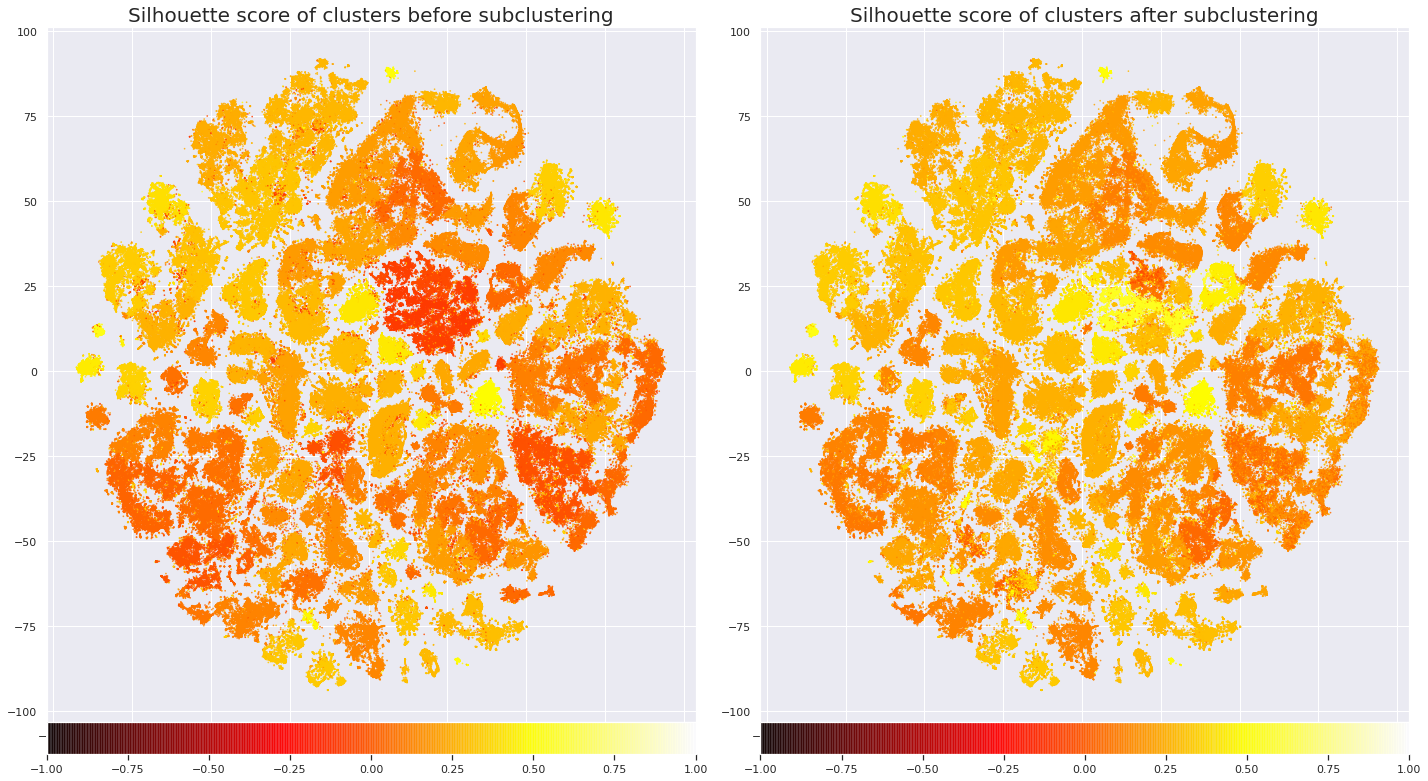

In [10]:

plt.rcParams["figure.figsize"] = [20, 12]
plt.rcParams["figure.autolayout"] = True
sns.set_theme(style="darkgrid")
plt.subplot(121)
points1 = plt.scatter(embeddings.loc[:,'tSNE_1'], embeddings.loc[:,'tSNE_2'], c=embeddings.loc[:,'clustering'],cmap='hot', alpha = 0.8, s = 0.5, vmin=-1, vmax = 1)
plt.colorbar(orientation = "horizontal", pad = 0)
plt.title("Silhouette score of clusters before subclustering", fontsize = 20)
ax3 = plt.subplot(122)
points2 = plt.scatter(embeddings.loc[:,'tSNE_1'], embeddings.loc[:,'tSNE_2'], c=embeddings.loc[:,'subclustering'],cmap='hot', alpha = 0.8, s = 0.5,  vmin=-1, vmax = 1)
plt.title("Silhouette score of clusters after subclustering", fontsize = 20)
plt.colorbar(orientation = "horizontal", pad = 0)
plt.tight_layout()
    
plt.show()

In [143]:
scores_with_subclustering
scores_wo_subclustering
sil_scores = pd.DataFrame()
sil_scores["Clusters"] = scores_with_subclustering.keys()
sil_scores["Scores_without_Subclustering"] = [scores_wo_subclustering.get(sil_scores.iloc[i,0]) for i in range(0, len(sil_scores))]
sil_scores["Scores_with_Subclustering"] = [scores_with_subclustering.get(sil_scores.iloc[i,0]) for i in range(0, len(sil_scores))]
data = sil_scores.melt('Clusters', var_name='Scores_with_Subclustering', value_name='Scores_without_Subclustering')


<ipython-input-143-f714311acdeb>:7: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  data = sil_scores.melt('Clusters', var_name='Scores_with_Subclustering', value_name='Scores_without_Subclustering')


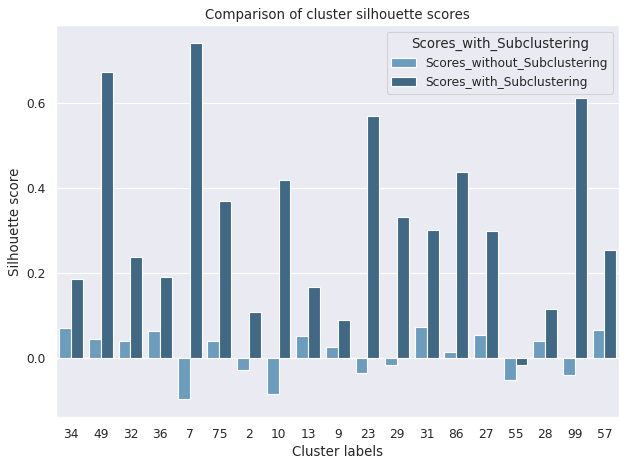

In [150]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

sns.set_theme(style="darkgrid")
ax = sns.barplot(x="Clusters", y="Scores_without_Subclustering", hue = "Scores_with_Subclustering", data=data,  palette="Blues_d")
plt.xlabel("Cluster labels")
plt.ylabel("Silhouette score")
plt.title("Comparison of cluster silhouette scores")
plt.show()

# Saving the object with subclustering silhouette scores and brain annotations

In [53]:
with open("/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/atlas_with_sublcustering.pkl", "wb") as f:
    pickle.dump(new_atlas, f)

In [2]:
with open("/staging/leuven/stg_00002/lcb/ijanic/projects/subclustering/atlas_with_sublcustering.pkl", "rb") as f:
    atlas_obj = pickle.load(f)